In [1]:
pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
      --------------------------------------- 0.1/3.0 MB 1.3 MB/s eta 0:00:03
     -- ------------------------------------- 0.2/3.0 MB 1.5 MB/s eta 0:00:02
     --- ------------------------------------ 0.3/3.0 MB 1.8 MB/s eta 0:00:02
     --- ------------------------------------ 0.3/3.0 MB 1.8 MB/s eta 0:00:02
     ---- ----------------------------------- 0.3/3.0 MB 1.5 MB/s eta 0:00:02
     ----- ---------------------------------- 0.4/3.0 MB 1.4 MB/s eta 0:00:02
     ------ --------------------------------- 0.5/3.0 MB 1.5 MB/s eta 0:00:02
     ------ --------------------------------- 0.5/3.0 MB 1.3 MB/s eta 0:00:02
     ------- -------------------------------- 0.6/3.0 MB 1.4 MB/s eta 0:00:02
     -------- ------------------------------- 0.6/3.0 MB 1.4 MB/s eta 0:00:02
     ---------- ----------------------------- 0.7/3.0 MB 1.4 MB/s eta 0:00:02
     ----------- ---------------------------- 0.9/3.0 MB 1.5 MB/s eta 0

# Data Collection

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Step 1: Download historical stock data
stock_symbol = 'AAPL'  # Example: Apple Inc.
data = yf.download(stock_symbol, start='2000-01-01')
data = data[['Close']]  # We'll only use the closing prices

# Save to CSV (optional)
#data.to_csv('/mnt/data/stock_data.csv')


[*********************100%%**********************]  1 of 1 completed


# Data Preprocessing

In [3]:
# Step 2: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_data_length = len(data) - 30  # Exclude the last 30 days
train_data = scaled_data[:train_data_length]

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60  # 60 days of historical data to predict the next day's price
X_train, y_train = create_dataset(train_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


# Model Training

In [4]:
# Step 3: Model Training
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=1, epochs=1)


6065/6065 [==============================] - 125s 20ms/step - loss: 6.0648e-04


# Prediction

1/1 [==============================] - 2s 2s/step


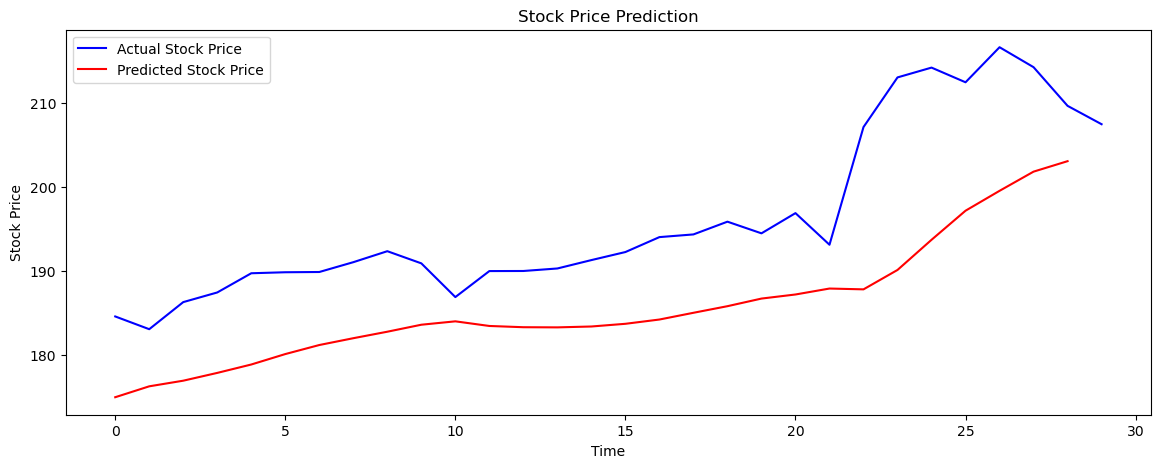

In [5]:
# Prepare test data
test_data = scaled_data[train_data_length - time_step:]
X_test, y_test = create_dataset(test_data, time_step)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Predict the prices
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Compare with actual prices
actual_prices = data['Close'].values[train_data_length:]

# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Prediction for upcoming 1 week, 1 fortnight and 1 month

1/1 [==============================] - 0s 30ms/step


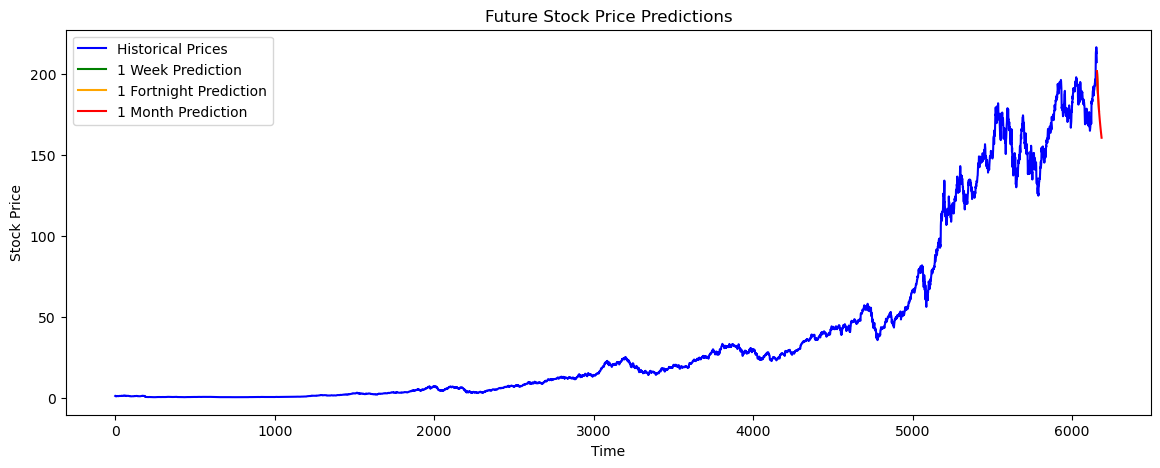

In [7]:
# Function to predict future prices
def predict_future_prices(model, data, steps, scaler):
    temp_input = list(data[-time_step:])
    temp_input = np.array(temp_input).reshape((1, time_step, 1))  # Convert to numpy array and reshape
    future_predictions = []
    
    for i in range(steps):
        future_pred = model.predict(temp_input)
        future_predictions.append(future_pred[0, 0])
        temp_input = np.append(temp_input[:, 1:, :], future_pred.reshape((1, 1, 1)), axis=1)
    
    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Predict future prices
future_1_week = predict_future_prices(model, scaled_data, 7, scaler)
future_1_fortnight = predict_future_prices(model, scaled_data, 14, scaler)
future_1_month = predict_future_prices(model, scaled_data, 30, scaler)

# Plot future predictions
plt.figure(figsize=(14, 5))
plt.plot(range(len(data)), data['Close'], color='blue', label='Historical Prices')
plt.plot(range(len(data), len(data) + 7), future_1_week, color='green', label='1 Week Prediction')
plt.plot(range(len(data), len(data) + 14), future_1_fortnight, color='orange', label='1 Fortnight Prediction')
plt.plot(range(len(data), len(data) + 30), future_1_month, color='red', label='1 Month Prediction')
plt.title('Future Stock Price Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Evaluation

RMSE: 13.161809790869974


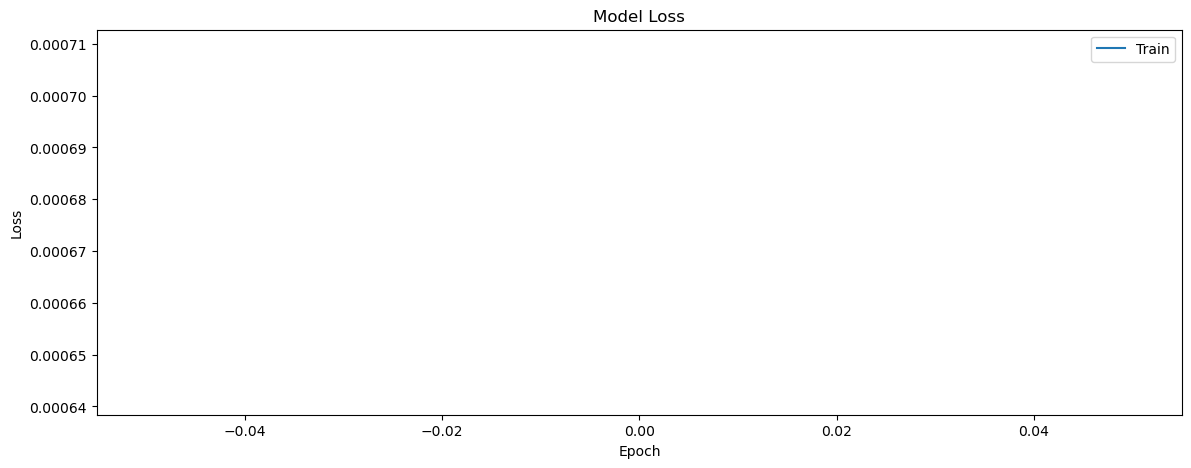

In [13]:
# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean(((predictions - actual_prices) ** 2)))
print(f'RMSE: {rmse}')

# Plot the loss function vs number of epochs
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper right')
plt.show()



# Report